In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Scipy gaussian kernel estimation

Scipy comes with gaussian KDE out of the box: [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).  As the docs say:

>  It includes automatic bandwidth determination. The estimation works best for a unimodal distribution; bimodal or multi-modal distributions tend to be oversmoothed.

For multi-dimensional data, the convention is:

> ... otherwise a 2-D array with shape (# of dims, # of data).

In [ ]:
data = np.random.normal(loc=2.0, scale=1.5, size=20)

kernel = scipy.stats.gaussian_kde(data)

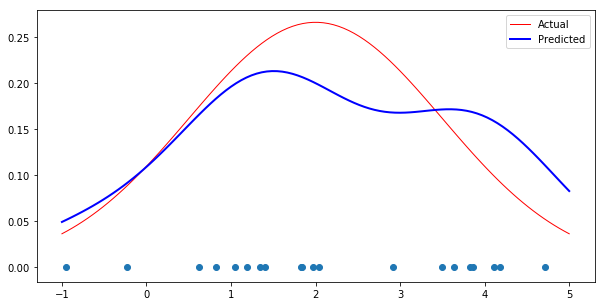

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

x = np.linspace(-1, 5, 100)

var = 2 * 1.5 ** 2
y = np.exp(-(x-2)**2/var) / np.sqrt(var * np.pi)
ax.plot(x, y, color="red", linewidth=1)

y = kernel(x)
ax.plot(x, y, color="blue", linewidth=2)
_ = ax.legend(["Actual", "Predicted"])

_ = ax.scatter(data, data * 0)

## Two dimensional case